## 1 Introduction
Sentiment analysis is commonly used in marketing and customer service to answer questions such as "Is a product review positive or negative?" and "How are customers responding to a product release?" etc. 

Topic modeling discovers the abstract "topics" in a corpus of texts. The results from topic modeling analysis can be used in sentiment analysis. For example, they can be used to split texts into different subsets and allow us to train a separate sentiment model for each of the subsets. Training separate sentiment models for different subsets can lead to more accurate predictions than using a single model for all the texts. 

The purpose of this notebook is to illustrate how to discover and visualize topics from a corpus of Twitter tweets using Jupyter notebook. 

## 2 Data
### 2.1 Data Source
The dataset used in his example is based on the [Sentiment140][data link] dataset. The Sentiment140 dataset has approximately 1,600,000 automatically annotated tweets and 6 fields for each tweet. For illustration purpose, a sample of the Sentiment140 dataset will be used. This sample has 160,000 tweets and two fields for each tweet - the polarity of the tweet and the text of the tweet. The sample dataset is located <a href="http://azuremlsamples.azureml.net/templatedata/Text - Input.csv">here</a>. 

Download this dataset by running the following command

    !curl -L -o mydatafile.csv http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv

After downloading the dataset, upload it to OneDrive or Dropbox as "mydatafile.csv" and import it into this notebook using the "Data" menu. 


### 2.2 Read and Prepare Data
The following lines of code read the data from my blob storage into the current session.
[data link]: http://help.sentiment140.com/ 
[ase link]: http://storageexplorer.com/
[blob link]: https://azure.microsoft.com/en-us/documentation/articles/storage-introduction/

In [1]:
!curl -L -o mydatafile.csv http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.8M  100 11.8M    0     0  4738k      0  0:00:02  0:00:02 --:--:-- 4742k


In [2]:
!ls

5 ML 5 Analyse IRIS scikit-learn.ipynb	       mydatafile.csv
ACP Iris Fisher.ipynb			       Numpy.ipynb
Analyse IRIS scikit-learn.ipynb		       nyc_neighborhoods.csv
Azure Notebooks - Welcome.ipynb		       oil_price.csv
Bokeh.ipynb				       Pandas.ipynb
Classification avec Carto.ipynb		       PixieDust.ipynb
Discover Sentiments in Tweets.ipynb	       Python.ipynb
Folium Maps.ipynb			       README.html
foo.csv					       Seaborn.ipynb
FSharp for Azure Notebooks.ipynb	       shell.log
Geocodage.ipynb				       Statistiques descriptives.ipynb
Getting to your Data in Azure Notebooks.ipynb  test.ipynb
Introduction to Python.ipynb		       TITANIC Kaggle.ipynb
Introduction to R.ipynb			       tree.dot


In [3]:
import os
import pandas as pd

dirname = os.getcwd()

mydata = pd.read_csv("mydatafile.csv", header=0)
print(mydata.shape)

# use 10000 for testing
mydata = mydata[:10000] 
mydata.head()

(160000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Before doing analysis, we can clean up the text by: 1) removing the twitter handle, 2) removing numbers, and 3) changing to lower case.

In [4]:
import re

#%% clean data
def clean_text(mystring): 
    mystring = re.sub(r"@\w+", "", mystring) #remove twitter handle
    mystring = re.sub(r"\d", "", mystring) # remove numbers  
    mystring = re.sub(r"_+", "", mystring) # remove consecutive underscores
    mystring = mystring.lower() # tranform to lower case    
    
    return mystring.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)

Then we can tokenize the text data using the following line of code.

In [5]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]

## 3 Identify Topics

### 3.1 Calculate tf-idf matrix
In order to use non-negative matrix factorization, we'll first calculate the tf-idf (term frequency-inverse document frequency) matrix. The value of tf-idf reflects the number times a word appears in the *document* after adjusting for the frequency of the word in the *corpus*. 

When calculating the tf-idf matrix, we can filter out words like "being" and "for" which are called stop words. In the following we filter out the stop words as defined by the [scikit-learn][sklearn link] package. You can expand the list of stop words by adding your own stop words to the "custom\_stop\_words" variable.

[sklearn link]: http://scikit-learn.org/stable/ 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size {} x {}".format(*tfidf.shape[:2]))

Created document-term matrix of size 10000 x 13379


### 3.2 NMF Analysis
If we use **X** to represent a **document-word** matrix with tf-idf values, non-negative matrix factorization factorizes the matrix into two matrices **W** and **H**, representing **document-topic** and **topic-word** matrices, respectively, as shown in the [following figure][pic 1]. The matrix **W** allows us to compare texts and determine which ones are similar. The matrix **H** tells us the top words in any given topic and we can use visualization to better undertand the topics. 

For any new text represented by **X_new**, we can make predictions in the sense that the **W_new** value can be computed from the **H** matrix.

Other topic finding models (e.g., Latent Dirichlet Allocation (LDA)) are also available in the [scikit-learn][sklearn link] package but are not covered here. Compared with LDA, NMF has cheaper computation cost and is a good choice for short text analysis.  

[sklearn link]: http://scikit-learn.org/stable/

[![Figure 1][pic 1]][pic 1] 

[pic 1]: https://cloud.githubusercontent.com/assets/9322661/18445719/ea601214-78ec-11e6-9858-b29d62e29c9e.png

Now we can use NMF on the derived tf-idf matrix. We specify the number of topics to be 3. 

In [7]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated factor W of size {} and factor H of size {}".format(W.shape, H.shape))

feature_names = vectorizer.get_feature_names()

n_top_words = 10

#%% print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #{}:".format(topic_idx))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated factor W of size (10000, 3) and factor H of size (3, 13379)
Topic #0:
good day work just today morning going like night really

Topic #1:
quot love http just com know amp new like best

Topic #2:
thanks following ff lol got haha great hey hope follow



## 4 Visualize Topics with Word Cloud
### 4.1 Install wordcloud package
To better communicate the topics found, we can use the [wordcloud][wordcloud link] package. Since this package is not pre-installed, we need to install it here. The command for installing packages in Azure ML notebooks is "!pip install packagename".

[wordcloud link]: https://github.com/amueller/word_cloud

In [8]:
!pip install --upgrade pip
!pip install wordcloud~=1.2.1

Requirement already up-to-date: pip in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (18.1)
    100% |████████████████████████████████| 174kB 7.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for wordcloud ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/86/8a/5c/2f462d4839a593d10e2458d4626cd20b664a04f6b7aa02859f
Successfully built wordcloud


### 4.2 Prepare topics for wordcloud
The following code saves the topics into separate sorted lists. 

In [9]:
#%% create pandas dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_{}".format(topic_idx)] = topic

mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []
for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: \
                        myword[1], reverse=True)

### 4.3 Visualize topics
The code below generates wordcloud for the 3 topics we identified from NMF. Larger fonts indicate higher weights of the words in a topic and the colors are randomly assigned. Compared with a simple list, from a word cloud we can better understand the relative frequency of all the words. 

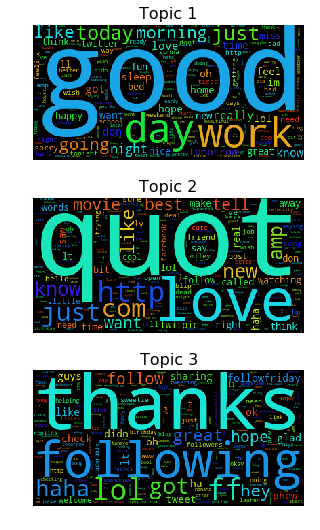

In [10]:
%matplotlib inline

from wordcloud import WordCloud 
import matplotlib.pyplot as plt

def wdc(*mywords_topic):
    n_row = len(mywords_topic)
    n_col = 1
    plt.figure(figsize=(n_col * 3 * 1.618, n_row * 3))    
    wordcloud = WordCloud()
    for index, item in enumerate(mywords_topic, start=1):
        wordcloud.fit_words(item)
        plt.subplot(n_row, n_col, index)
        plt.title('Topic {}'.format(index), size=16)
        plt.imshow(wordcloud)
        plt.axis("off")

wdc(mywords_topic1, mywords_topic2, mywords_topic3)

## 5 Discussion
For any new tweet, we first calculate its tf-idf matrix (**X**) and then calculate its **W** matrix. This will then allow us to assign the new tweet to a segment and predict its sentiment (e.g. positive sentiment vs negative sentiment on a product).

The following code shows how to calcuate the W matrix for new tweets that have been cleaned beforehand. For illustration purpose, these 5 tweets are the first 5 from the corpus used in the analysis.  

In [11]:
# prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
W_new = nmf.transform(tfidf_new)

---  
Created by a Microsoft Employee.  
Copyright (C) Microsoft. All Rights Reserved.